In [422]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
from scipy.stats import lognorm, chi2, norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH

In [423]:
dfile = os.path.join(DATA_PATH, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')
uvd = UVData()
uvd.read(dfile)
print(uvd.get_antpairs())
print(uvd.Nbls,uvd.Nfreqs, uvd.Nspws, uvd.Ntimes)
# print(dir(uvd)) 

Telescope eorsky is not in known_telescopes.


[(0, 11), (0, 12), (11, 12)]
3 384 1 982


In [424]:
cosmo = hp.conversions.Cosmo_Conversions()
print(cosmo)

Cosmo_Conversions object at <0x1c213819b0>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


In [425]:
# Creating the beamfile
beam_freqs = uvd.freq_array # in Hz
uvb = hp.PSpecBeamGauss(fwhm=0.21170844, beam_freqs=beam_freqs[0])

In [426]:
# Converting units
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='pI')
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [427]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)         #even
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)          #odd

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [428]:
ds.rephase_to_dset(0)

In [429]:
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [430]:
# Specify which baselines to include
baselines = [(0, 11)]

In [431]:
# Define uvp
# Polarization pairs for this specific simulation data is 'pI'
# spw_range length = number of delays
uvp = ds.pspec(baselines, baselines, (0, 1), [('pI', 'pI')], spw_ranges=[(0, 300)],  
               input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (0, 300)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((0, 11), (0, 11))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


In [432]:
# return the nearest delay (in the dlys array) from the rough input delay
def get_delay(dly, key):
    dlys = uvp.get_dlys(key[0]) * 1e9
    dlys = np.asarray(dlys)
    idx = (np.abs(dlys - dly)).argmin()
    return dlys[idx]

def get_dly_ind(i_dly, f_dly, key):
    power = np.real(uvp.get_data(key))
    ini_dly = get_delay(i_dly, key)
    fin_dly = get_delay(f_dly, key)
    dlys = uvp.get_dlys(key[0]) * 1e9
    i_index = int(np.where(dlys == ini_dly)[0])
    f_index = int(np.where(dlys == fin_dly)[0])
    return i_index, f_index

In [433]:
spw = 0
blp = ((0, 11), (0, 11))
pol = ('pI', 'pI')
key = (spw, blp, pol)
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

In [434]:
data = power[0:201][:,get_dly_ind(1000, 4000, key)[0]:get_dly_ind(1000, 4000, key)[1]]

x = []
data = np.transpose(data)
for i in range(len(data)):
    a = data[i][0]
    for j in range(len(data[i])-1):
        a += data[i][j]
    x.append(a)

In [435]:
popt = stats.chi2.fit(x, 200, loc=1e8, scale=1e8)

(array([8.50275768e-10, 1.70055154e-09, 1.51160137e-09, 1.32265120e-09,
        2.83425256e-10, 4.72375427e-10, 9.44750854e-11, 0.00000000e+00,
        3.77900342e-10, 0.00000000e+00, 9.44750854e-11]),
 array([7.94845175e+07, 2.28566225e+08, 3.77647932e+08, 5.26729640e+08,
        6.75811347e+08, 8.24893055e+08, 9.73974762e+08, 1.12305647e+09,
        1.27213818e+09, 1.42121988e+09, 1.57030159e+09, 1.71938330e+09]),
 <a list of 11 Patch objects>)

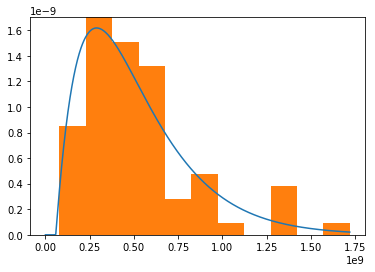

In [436]:
fit_x = np.linspace(0, np.sort(x)[-1], 1000)
plt.plot(fit_x, stats.chi2.pdf(fit_x, popt[0], loc=popt[1], scale=popt[2]))
plt.hist(x, bins='auto', density=True)